# Cloud Diffusion Part 1: Scale Invariance in Natural Image Sets
Diffusion models function by progressively adding noise to an image set and training a model to separate out the signal from the noise. The noise profile used by these models is white noise --  that is, noise based on independent normal distributions at each point whose mean and variance is independent of the scale. We argue here that most natural image sets are closer (in a quantifiable sense) to a different probability distribution that emphasizes large scale noise correlation while de-emphasizing short scale noise. These so called "Scale Invariant Noise" profiles can be incorporated into diffusion models and may lead to faster inference, greater image diversity, and higher quality images.

This is the first notebook in a series:
1. [Cloud Diffusion Part 1: Scale Invariance (this notebook)](./CD_Scale_Invariance.ipynb)
2. [Cloud Diffusion Part 2: Overview](./CD_Overview.ipynb)
3. [Cloud Diffusion Part 3: Training](./CD_Training.ipynb)
4. [Cloud Diffusion Part 4: Inference](./CD_Inference.ipynb)

In [2]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import time
import importlib
import data
import helpers
import RealFFT
from RealFFT import fft
from RealFFT import ifft
from RealFFT import rfft
from RealFFT import irfft
from IPython.display import clear_output

In [27]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(RealFFT)

<module 'RealFFT' from '/Users/ac.randono/Python Projects/AI Experiments/Scale Invariance/RealFFT.py'>

In [3]:
device = helpers.getDevice()
print(device)

mps


## A Wager
To introduce theager concepts that we will make extensive use of in this project, we begin with a hypothetical scenario. Suppose you are professional gambler and we challenge you to a bet. The bet is the following. We give you a set of natural images (mostly outdoor scenes of cars, animals, landscapes, etc..). For simplicty assume the images are square with dimensions $96\times 96$ pixels, and they are black and white with pixel values between $0$ and $1$. 

We've selected a set of images at random from the set, and for each image we choose two points at random. We tell you the pixel value of one of these points. The bet is to guess the value of the other pixel. The closer your guess is to the actual pixel value, the more points you will be rewarded.

You have to choose the values of the second pixel, and you have to choose how much to wager. This is summarized in the table below:

|  Pixel 1 (x,y) | Pixel 1 Value | Pixel 2 Coords | Pixel 2 Value | Wager |
|:---------|:--------:|:---------:|:---------:|:---------:|
|  (12,45)   |  .96   |  (82,35)   |  **???**   |  **\$\$\$**   |
|  (56,23)   |  .25   |  (36,48)   |  **???**   |  **\$\$\$**   |
|  (76,12)   |  .34   |  (87,21)   |  **???**   |  **\$\$\$**   |
|  (43,26)   |  .87   |  (42,11)   |  **???**   |  **\$\$\$**   |
|  (55,95)   |  .56   |  (27,19)   |  **???**   |  **\$\$\$**   |
|  (23,42)   |  .12   |  (34,62)   |  **???**   |  **\$\$\$**   |
|  (47,64)   |  .33   |  (36,25)   |  **???**   |  **\$\$\$**   |

We give you the image set, and you are free to analyze it using any means. But we do not give you any information about the images that have been randomly chosen.

At first glance, this may appear to be a losing game. However, as we will argue below, there are strategies for selecting a pixel value and a wager amount that will potentially make money. This is because natural images sets have correlations between neighboring pixels, and you are given the pixel coordinates. These correlations tend to fall off with distance, but since you are free to choose your wager, you can adjust your strategy accordingly. 

Perhaps surprisingly, these correlations between neighboring pixels are the basis for our Cloud Diffusion model. Let's see how this works...

### The Image Set
First lets's discuss the image set for the wager. The image set, call it $Q$, is a filtered subset of the unlabeled STL10 dataset consisting of 100,000 images in a natural setting {e.g. cars, birds, animals}. This images are of medium resolution (96x96 pixels) with a wide diversity of natural images. The original images are RGB color images, but we've converted them to grayscale first. We will return to the RGB color model in [Cloud Diffusion: Color Models](./Cloud_Diffusion_Color.ipynb).

First we filter the dataset by eliminating images with unnatural features. Many of the images are letterboxed with large black bands on the top and bottom, and sometimes on the left and right sides. These are not natural features as they arise from image cropping. To filter these, we simply seek out images with large color blocks of black or white pixels. In practice, using a fixed kernel to black or white blocks works very well for this, and it removes roughly 23% of the unwanted images.

### The Data Sets:

<b>Clean Dataset:</b> STL10 unlabeled dataset consisting of 100,000 natural setting images
- Filter out images with letterboxes
- Approximately 37% of images removed
- Clip the dataset length so it is divisible by batch size (64)
- Grayscale transformation

<b>Dirty Dataset (not used):</b> We retain the omitted images for visualization
- Contains Filtered images with letterboxes using a kernel to identify black or white color blocks

#### Loading the Data

In [4]:
clean_dataset, dirty_dataset = data.get_datasets(batch_size=64)
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True)

37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


### Visualizing the data

#### Omitted Images
Here we show the omitted images. The filter was intended to remove images with large bars on the top/bottom or left/right caused by cropping and resizing. While some images not fitting this criteria were also thrown out, the filter was largely successful in doing its intended job.

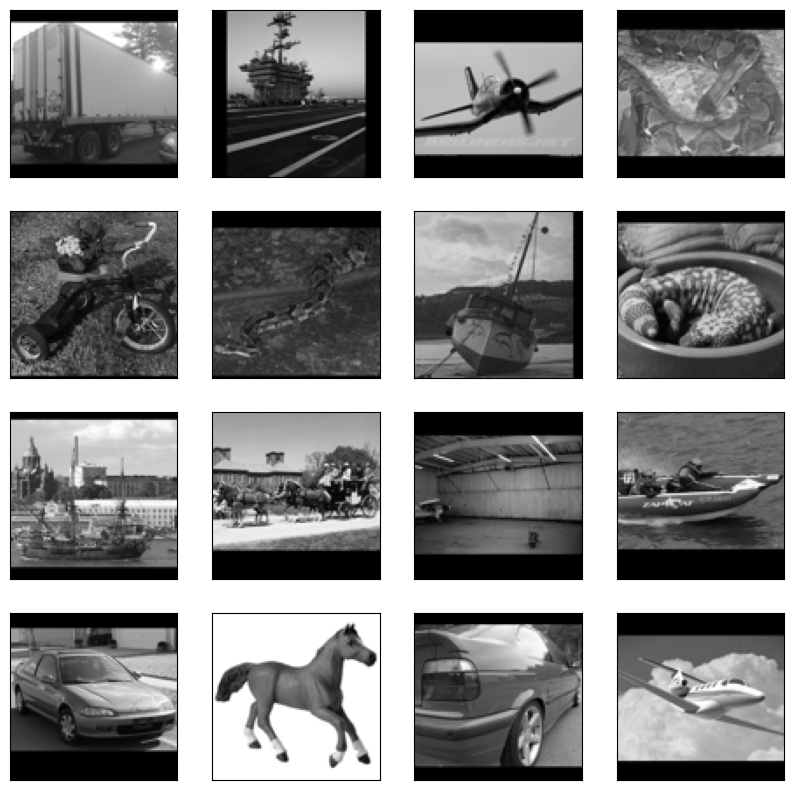

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(16):
    randint = np.random.randint(len(dirty_dataset))
    image0 = dirty_dataset[randint][0].squeeze()
    axs[i//4][i%4].imshow(image0, vmin=0, vmax=1, cmap="gray")

# Remove axes labels
plt.setp(axs, xticks=[], yticks=[])

plt.show()

#### The Filtered Image Set
The remaining filtered image set consists of 981 batches, each with 64 images, for a total of 62,784 images.

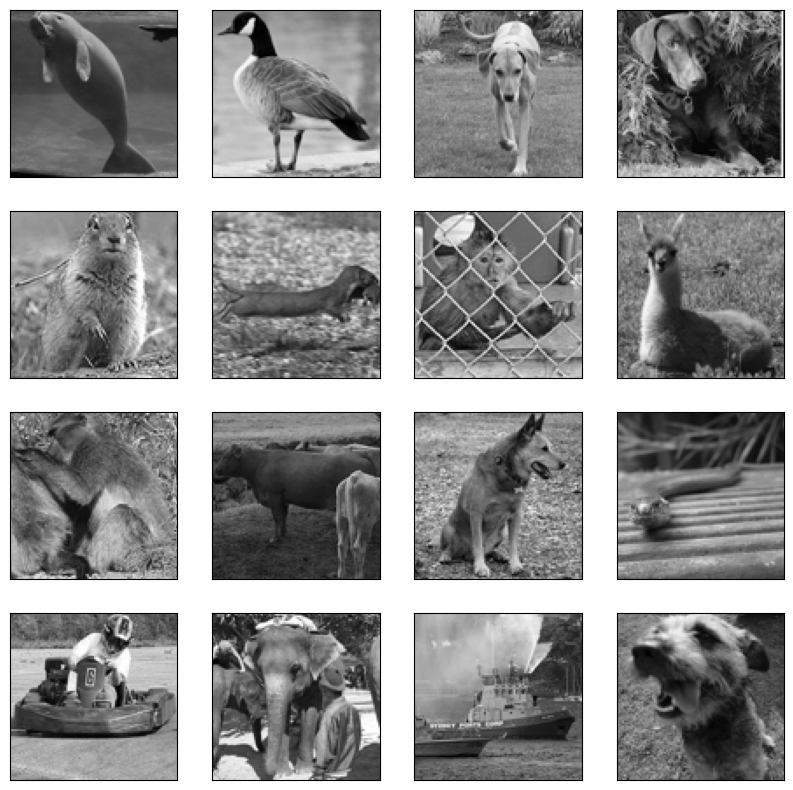

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(16):
    randint = np.random.randint(len(clean_dataset))
    image0 = clean_dataset[randint][0].squeeze()
    axs[i//4][i%4].imshow(image0, vmin=0, vmax=1, cmap="gray")
    
# Remove axes labels
plt.setp(axs, xticks=[], yticks=[])

plt.show()

## Calculating the Means and Standard Deviations
To come up with a strategy for your wager, you need to first need to analyze the data set. The first questions that may pop into your head are:
- What is the average pixel value at each point?
- Is the image brighter/darker in certain regions (say near the edges or at the focal point)?
- How much deviation from the mean is there at each pixel?

To answer these questions, you calculate the pixel-wise means and standard deviations. Let's do this below...

### Means and Standard Deviations
First, calculate the means, and standard deviations. Focus on the pixel-wise mean and std (the mean/std value for each pixel in the image set).

In [7]:
mu, std = helpers.get_mu_and_std(clean_dataset, device=device)

mu (min,max)=(0.3943358063697815,0.48275938630104065) || mu min/max difference=0.08842357993125916
std (min,max)=(0.21978823840618134,0.2498357743024826) || std min/max difference=0.03004753589630127


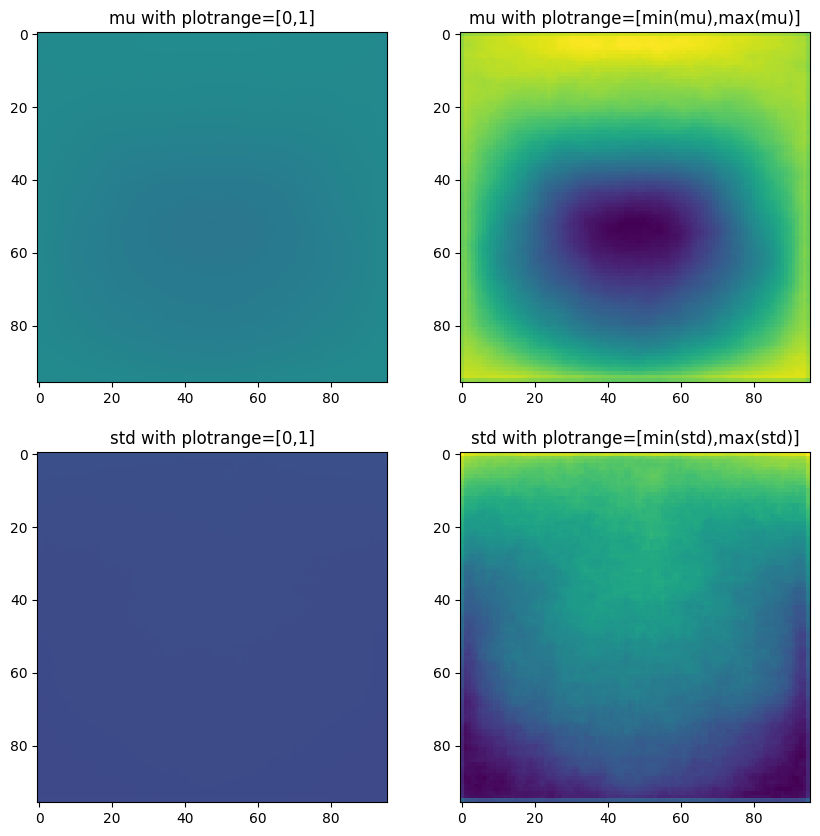

In [8]:
print(f"mu (min,max)=({mu.min()},{mu.max()}) || mu min/max difference={mu.max()-mu.min()}")
print(f"std (min,max)=({std.min()},{std.max()}) || std min/max difference={std.max()-std.min()}")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs[0][0].set_title("mu with plotrange=[0,1]")
axs[0][0].imshow(mu.to("cpu"), vmin=0, vmax=1)
axs[0][1].set_title("mu with plotrange=[min(mu),max(mu)]")
axs[0][1].imshow(mu.to("cpu"), vmin=mu.min(), vmax=mu.max())

axs[1][0].set_title("std with plotrange=[0,1]")
axs[1][0].imshow(std.to("cpu"), vmin=0, vmax=1)
axs[1][1].set_title("std with plotrange=[min(std),max(std)]")
axs[1][1].imshow(std.to("cpu"), vmin=std.min(), vmax=std.max())

plt.show()

The pixelwise mean, $\mu^{ij}$, is ever-so-slightly brighter near the tops of the images. This is to be expected of a set of natural images as lighting typically comes from the sky or overhead light. The effect is subtle, with a difference of less than .1 between min and max values of $\mu$, and it is overemphasized in the plot to reveal the structure. Similarly, the pixelwise std reveals slighlty more variation in pixel values near the top of the images. However, like the mean, the effect is very subtle.

Since the pixel means and stds are extremely uniform, you didn't gain a lot of information about the spatial correlations between pixels from these calculations. But you did find that the mean and std are very uniform, and you now know their values. You conclude that you are safe in normalizing the image set pixel-by-pixel (as opposed to normalizing by the global mean and std). So, for the remainder of the calculations you normalize each pixel of the input images using the calculated values of $\mu$ and $\text{std}$.

### The variance tensor
To get a better understanding of the spatial correlations between neighboring pixels you need more than just the pixel-by-pixel means and standard deviations. What you really need is the variance tensor, which gives you a measure of the correlation between a pixel at coordinates $(i,j)$ and another pixel at coordinates $(k,l)$. The variance tensor, $\Sigma$, is defined by:
$$
{\Sigma^{ij}}_{kl} = \mathbb{E}\left[(x^{ij}-\mu^{ij})(x_{kl}-\mu_{kl})\right]
$$
The diagonal component of the tensor $\Sigma^{ij}_{\text{diag}}={\Sigma^{ij}}_{ij}$ (no sum over repeated indices here) is the square of the standard deviation at each point, while the off-diagonal terms reveal correlations between neighboring pixels. We compute this tensor below for our dataset:

In [9]:
sigma = helpers.get_sigma(dataloader, mu, std, device=device)
sigma_diag = torch.einsum("ijij->ij", sigma)

Completed in 17.77540922164917 seconds.


Below we visualize the tensor for a handful of randomly chosen pixels. For example, for the chosen pixel $(k,l)=(16,84)$ we plot ${\Sigma^{ij}}_{16\,84}$ as an image:

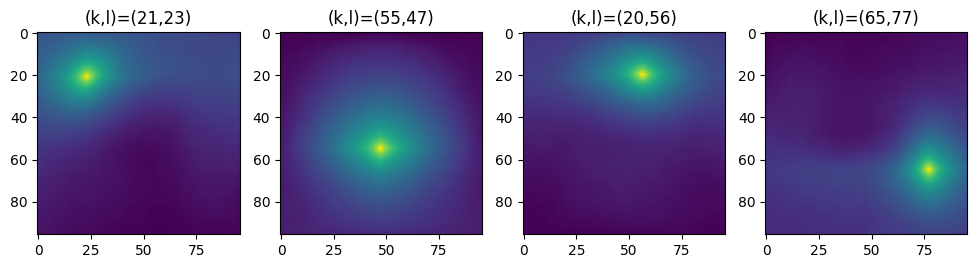

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 13))
points = [[21,23],[55,47],[20,56],[65,77]]

for n in range(4):
    k = points[n][0]
    l = points[n][1]
    axs[n].set_title(f"(k,l)=({k},{l})")
    axs[n].imshow(sigma[:,:,k,l].to("cpu"))
    
plt.show()

The plots reveal a rich structure of correlations between neighboring points. The variance tensor is peaked at the coordinates of the sample point $(i,j)$, but tails off slowly with distance from the point. The reason for this is easy to understand. In natural images, the values of individual pixels are usually not isolated to a single pixel. Real images have big blocks of color and value, which translates into correlations between neighboring pixels. The correlations fall off with distance, and that is exactly what we are seeing in the plots above. For example, suppose we sample from a bunch color images of outdoor scenes and we sample one pixel from one image and find it is light-blue. Chances are good that this pixel is part of the sky, and because of that the surrounding pixels are also likely to be light blue. The further away you go from the sampled pixel the less likely it is to be light blue (because the sky doesn't likely stretch across the whole image). 

As it turns out, the fall-off function is characteristic of the image set. The fact that the variance tensor is not diagonal makes it challenging to analyze. But, there are ways around this. If we transform to Fourier space and analyze the images there the corresponding complex variance tensor turns out to be diagonal, and it has a surpising structure. Let's try that...

## Complex Distributions
The Fourier transform of the image set is complex, so to analyze the set we need to work with complex distributions. In contrast to real distributions, complex normal distributions are characterized by the mean $M^{ij}=\mathcal{F}(\mu^{ij})$ and *two* complex variance tensors given by
$$
\begin{eqnarray}
{\Gamma^{ij}}_{kl} &=& \mathbb{E}\left[(Z^{ij}-M^{ij})(Z^*_{kl}-M^*_{kl})\right] \\
{C^{ij}}_{kl} &=& \mathbb{E}\left[(Z^{ij}-M^{ij})(Z_{kl}-M_{kl})\right]
\end{eqnarray}
$$
By decomposing the Fourier image into its real and imaginary parts, $Z^{ij}=X^{ij}+iY^{ij}$, we can express this interms of the variances between these parts. Dropping indices for clarity, we express the four variances by:
\begin{eqnarray}
\Sigma_{XX} &=& \mathbb{E}\left[(X-\mu_X)(X-\mu_X)^T \right] \\
\Sigma_{YY} &=& \mathbb{E}\left[(Y-\mu_Y)(Y-\mu_Y)^T \right] \\
\Sigma_{XY} &=& \mathbb{E}\left[(X-\mu_X)(Y-\mu_Y)^T \right] \\
\Sigma_{YX} &=& \mathbb{E}\left[(Y-\mu_Y)(X-\mu_X)^T \right]
\end{eqnarray}
The variances $\Gamma$ and $C$ can then be expresses in terms of the above by
\begin{eqnarray}
\Gamma &=& \Sigma_{XX}+\Sigma_{YY}+i\left(\Sigma_{YX}-\Sigma_{XY}\right) \\
C &=& \Sigma_{XX}-\Sigma_{YY}+i\left(\Sigma_{YX}+\Sigma_{XY}\right)
\end{eqnarray}
For natural image sets, the real and imaginary parts are approximately statistically independent, which implies $\Sigma_{XY}\approx 0$ and $\Sigma_{YX}\approx 0$. Thus, $\Gamma$ and $C$ are real (approximately). Furthermore, there are correlations between the $\Sigma_{XX}$ and $\Sigma_{YY}$. For a real-valued image $x^{ij}$, its Fourier transform $Z^{ij}=\mathcal{F}(x^{ij})$ is restricted by $Z^{\tilde{i}\tilde{j}}=(Z^{ij})^*$ where $\tilde{i}\tilde{j}$ represents the coordinates of the pixel $ij$ mirrored about the origin. This means that half the points are not independent of the other half. In terms of the variance tensors we have the relations:
$$
\begin{eqnarray}
{(\Sigma_{XX})^{ij}}_{kl} &=& {(\Sigma_{XX})^{ij}}_{\tilde{k}\tilde{l}} \\
{(\Sigma_{YY})^{ij}}_{kl} &=& -{(\Sigma_{YY})^{ij}}_{\tilde{k}\tilde{l}}
\end{eqnarray}
$$
This gives a simple relation on the complex variances:
$$
{C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}\,.
$$
Since $C$ is entirely determined by $\Gamma$, we can usually get away with just focusing on $\Gamma$ for real image sets. 

We compute $\Gamma$ and $C$ for our dataset below:

In [11]:
Gamma, C = helpers.get_Gamma_and_C(dataloader, mu, std, device=device)

Completed in 90.30619072914124 seconds.


### Visualizing $\Gamma$ and $C$
We visualize ${\Gamma^{ij}}_{kl}$ and ${C^{ij}}_{kl}$ by fixing random values of $kl$ and plotting the 2d tensor for these fixed values. The pixels near the axes tend to be biased by artefacts from the Fourier transform of rectangular images. We mask these artefacts in the last two columns to highlight the diagonal nature of the variances. 

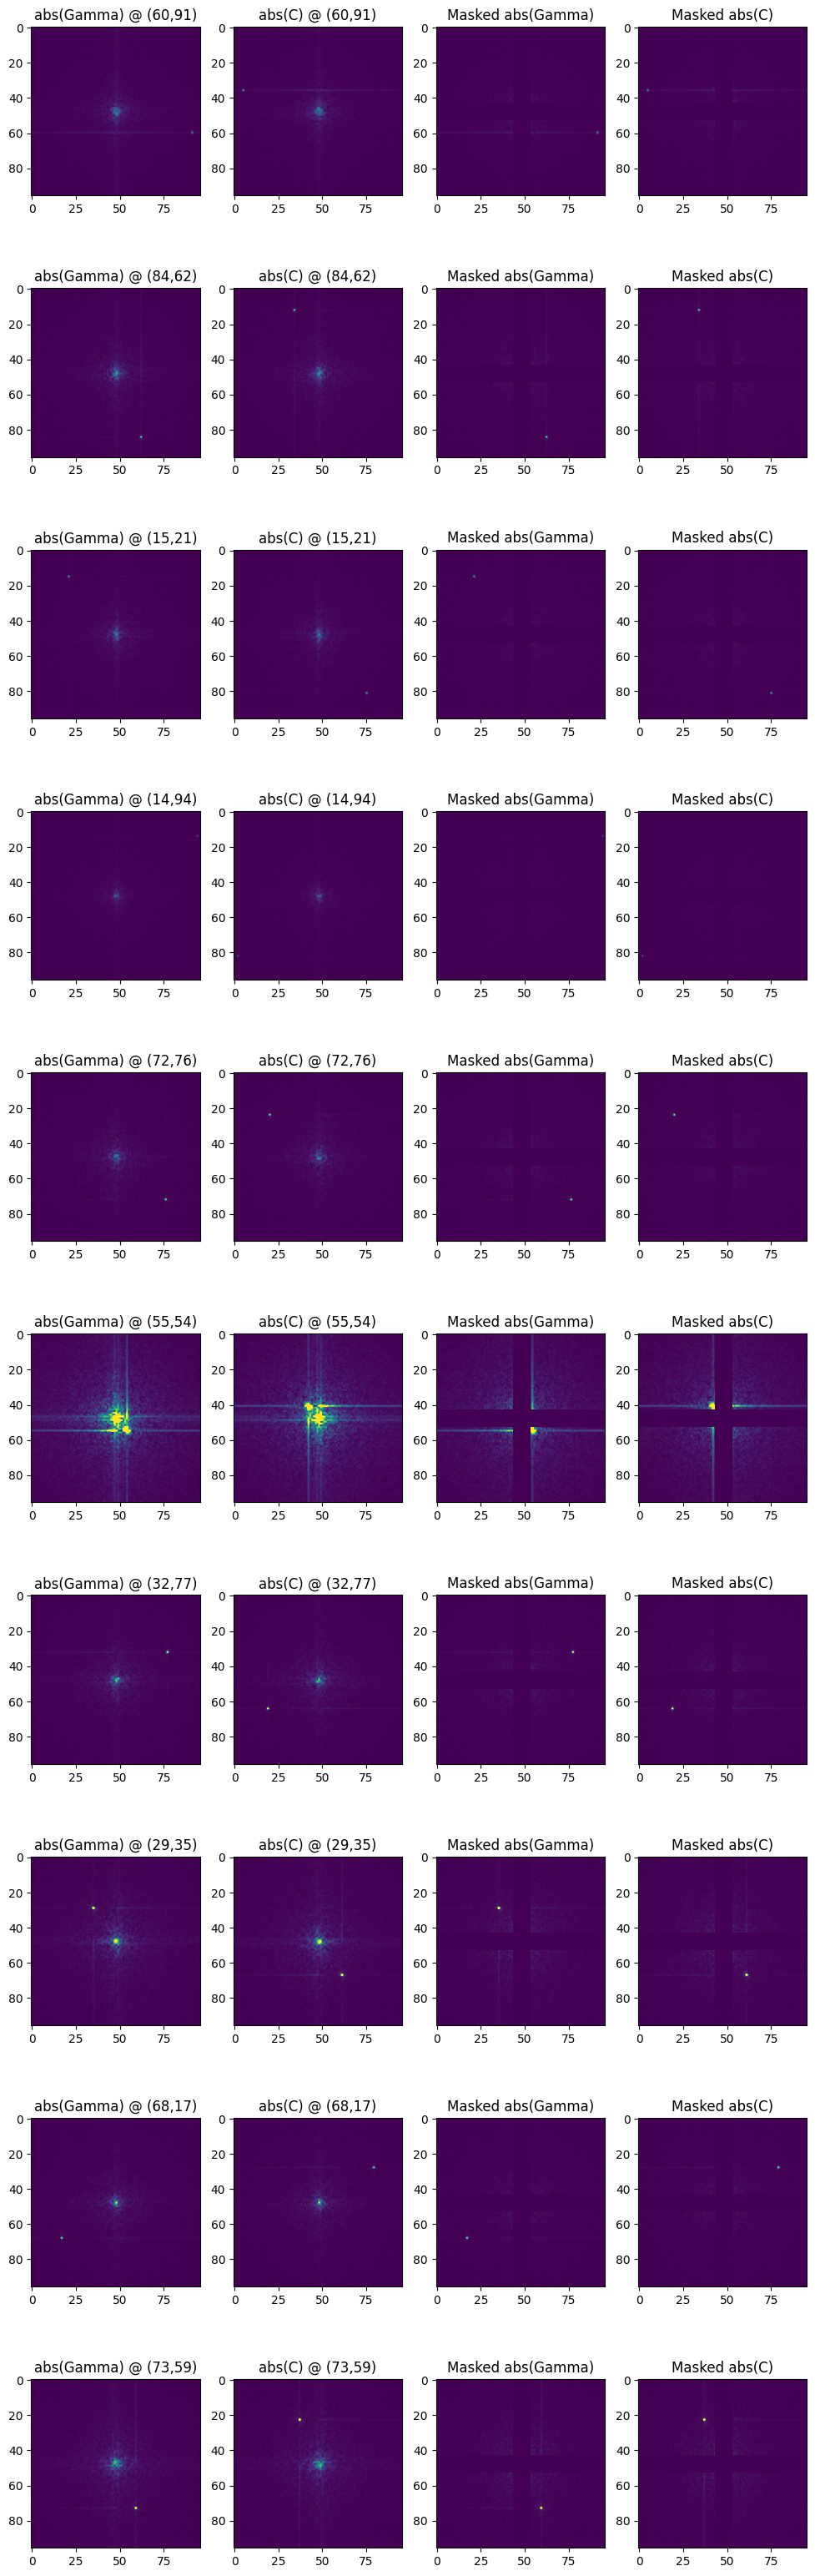

In [12]:
vmax = .05
nrows = 10
a=5
fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 40))


for n in range(nrows):
    unmasked_points = np.append(np.arange(0,96//2-a), np.arange(96//2+a, 96))
    i = unmasked_points[np.random.randint(len(unmasked_points))]
    j = unmasked_points[np.random.randint(len(unmasked_points))]
    #axs[n][].set_title(f"(i,j)=({i},{j})")
    axs[n][0].imshow(Gamma[:,:,i,j].abs().to("cpu"), vmin=0, vmax=vmax)
    axs[n][1].imshow(C[:,:,i,j].abs().to("cpu"), vmin=0, vmax=vmax)
    axs[n][2].imshow(helpers.mask_this(Gamma[:,:,i,j].abs().to("cpu"), a=a, R=10), vmin=0, vmax=vmax)
    axs[n][3].imshow(helpers.mask_this(C[:,:,i,j].abs().to("cpu"), a=a, R=10), vmin=0, vmax=vmax)

    axs[n][0].set_title(f"abs(Gamma) @ ({i},{j})")
    axs[n][1].set_title(f"abs(C) @ ({i},{j})")
    axs[n][2].set_title(f"Masked abs(Gamma)")
    axs[n][3].set_title(f"Masked abs(C)")
    
plt.show()

Ignoring the central cross near the axes, the variance tensors have a simple for that can be approximated by
$$
{\Gamma^{ij}}_{kl} \approx \Gamma^{ij}_{diag}\,\delta^i_k\delta^j_l \quad\quad {C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
where $\tilde{k}$ and $\tilde{l}$ represent the indeces $k$ and $l$ mirrored around the origin. The form of ${C^{ij}}_{kl}$ is expected as the original data set consists of real-valued images. The Fourier transform $Z^{ij}=\mathcal{F}(x^{ij})$ of a real image $x^{ij}$ satisfies $Z^{\tilde{i}\tilde{j}} = (Z^{ij})^*$. When the real and imaginary parts of $Z^{ij}$ are statistically independent (e.g $\Sigma_{XY}=\Sigma_{YX}\approx 0$), The variance tensors are real and they are related by ${C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}$. 

### Visualizing $\Gamma_{diag}$

We saw above that moving to Fourier space removes the correlations between neighboring points (which are neighboring wave-numbers, $\vec{k}$, in Fourier space). Most of the remaining information is contained in the diagonal component $\Gamma^{ij}_{\text{diag}} = {\Gamma^{ij}}_{ij}$ (no sum over repeated indices here). Let's dig deeper into the structure of $\Gamma_{\text{diag}}$. We plot $\Gamma^{ij}_{\text{diag}}$ as an image tensor below:

In [18]:
Gamma_diag = torch.einsum("ijij->ij", Gamma)

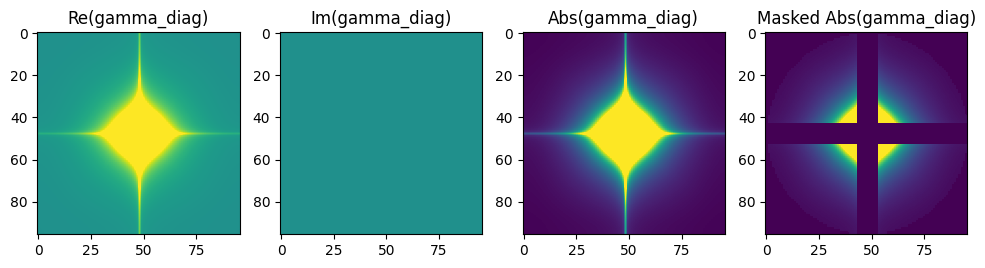

In [19]:
vmax=.7
a=5
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
axs[0].imshow(Gamma_diag.real.to("cpu"), vmin=-vmax, vmax=vmax)
axs[1].imshow(Gamma_diag.imag.to("cpu"), vmin=-vmax, vmax=vmax)
axs[2].imshow(Gamma_diag.abs().to("cpu"), vmin=0, vmax=vmax)
axs[3].imshow(helpers.mask_this(Gamma_diag.abs().to("cpu"), a=a, mask_value=-1000000), vmin=0, vmax=vmax)

axs[0].set_title("Re(gamma_diag)")
axs[1].set_title("Im(gamma_diag)")
axs[2].set_title("Abs(gamma_diag)")
axs[3].set_title("Masked Abs(gamma_diag)")

plt.show()

Above we plot the real, imaginary, and magnitude of $\Gamma_{diag}$. The plots reveal that $\Gamma_{diag}$ has a rich structure that is largely radially dependent, with some bias along the vertical and horizontal axes forming a central cross.

The central cross of the images is likely due to several factors:
1. The artificial prevalence of vertical and horizontal lines in the images from man-made structures (e.g. building edges, fence lines, etc..)
2. The natural prevalence of vertical and horizontal structures due to gravity (e.g. tree trunks, horizon lines, etc..)
3. The presence of black letterboxing bars on the edges of some cropped images (mostly filtered out with some residuals along the edges)
4. Commonly occuring artefacts from irregular boundary conditions on rectangular images

The first three can be controlled by applying a random rotation to the image set prior to analysis. The last point alludes to common artefacts from the Fourier transform itself as opposed to structures in the image set. They arise from images that do not have toroidially periodic boundary conditions. These are often removed by applying a Hamming window to taper the image to zero near the boundaries. However, Hamming window attenuation functions can obscure the radial dependence of $\Gamma$, so we will not employ this technique here. Rather we resort to a more crude method of masking out the central cross and values outside of a given radius in our visualizations. The masked tensors are shown in the last column, and they reveal the radial structure of $\Sigma$ more clearly.

From the masked tensor, we can see that $\Gamma_{diag}$ is dominated by its radial dependence so $\Gamma_{diag}\approx \Gamma_{diag}(|k|)$.

The plots reveal an interesting structure. Ignoring the central cross region, the tensor $C$ is close to zero. However, $\Gamma$ is approximately diagonal, with an amplitude that depends on position:
$$
{\Gamma^{ij}}_{kl} \approx \Gamma^{ij}_{diag}(|k|)\,\delta^i_k\delta^j_l \quad\quad {C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
where $\tilde{k}$ and $\tilde{l}$ represent the indeces $k$ and $l$ mirrored around the origin. In the next section we will dig deeper into the radial dependence of $\Gamma_{diag}(|k|)$.

# Radial Dependence of the Variance Tensor
Here we investigate the radial dependence of the standard deviation. In Fourier Space, Plotting the STD as a function of radius (normalized to one at the edges) we see a charateristic inverse relationship of the power spectrum with the radial distance from the origin. The linear dependence is tightened when we mask out the central cross region. The mask is shown in the plot below. The log-log plot of $\Sigma_{diag}$ vs radius is shown with the masked regions in light blue and light red. The unmasked points in this plot exhibit a highly linear relationship.

The plots suggest that when we ignore the central cross region, a reasonable approximation the variance tensors are given by
$$
{\Gamma^{ij}}_{kl} \approx \frac{A^2}{\lvert k\rvert^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
where $\tilde{k}$ and $\tilde{l}$ represent the indeces $k$ and $l$ mirrored around the origin, and $r=r(i,j)$ is the radius function normalized so the image center-edges are at $r=0.5$. $A$ and $\Delta$ are constants that we calculate below.

LinregressResult(slope=-2.999874532281494, intercept=-5.962816864117483, rvalue=-0.9857808519166401, pvalue=0.0, stderr=0.005746322410214519, intercept_stderr=0.006091514582514309)
From the slope of the log-log plot we determine the factors A and ∆:
A=0.050721345964071955
∆=1.499937266140747


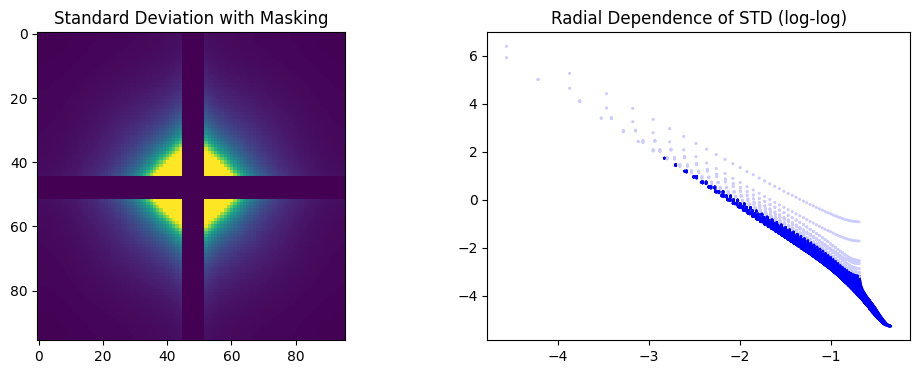

In [20]:
A, Delta = helpers.get_radial_dependence(Gamma, a=4, R=10)

So our plots determine that the diagonal variance has a power-law form with $\Delta \approx 1.5$. What does this mean? In the next section we will show how this relates to cloud noise.


## Cloud Noise
We've seen that the variance tensors for our dataset have the approxiate forms 
$$
{\Gamma^{ij}}_{kl} \approx \frac{A^2}{\lvert k\rvert^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl} \approx {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
with $\Delta \approx 1.5$. The variance tensors capture some critical information about the statistical structure of the image set. Assume for the moment that we were not dealing with a real image, but a complex normal distribution with zero mean, and variance precisely equal to the forms above. That is suppose our distribution is $\mathcal{N}_{\mathbb{C}}(0, \Sigma, C)$ with 
$$
{\Gamma^{ij}}_{kl} = \frac{A^2}{\lvert k\rvert^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl} = {\Gamma^{ij}}_{\tilde{k}\tilde{l}}
$$
and $\Delta = 1.5$. What does a typical sample from this distribution look like?

In fact, this distribution falls into a class of probability distributions called scale-invariant noise. Scale invariance refers to the special property that the distribution is self-similar upon dilations. In Fourier space, this means under the dilation $k^{ij}\rightarrow \lambda k^{ij}$ the variance tensor is an eigenstate:
$$
{\Gamma^{ij}}_{kl} \rightarrow \lambda^{-2\Delta} {\Gamma^{ij}}_{kl}\,.
$$
Thus, if we generate a sample from this distribution and zoom out or zoom in, the sample will look roughly the same (aside from the amplitude). This is why it is referred to as a scale-invariant distribution -- the probability density of the normal distribution is invariant (up to a constant multiplier) under rescaling.

The unique noise profile that is *strictly* invariant under rescaling is referred to as **white noise**, and it is the familiar noise that is used in ordinary diffusion models. White noise is unique in that the image of a a white noise set under the Fourier Transform still looks like white noise. Furthermore, the variance tensor in *real* space (and also in Fourier space) is diagonal:
$$
{(\Sigma_{white})^{ij}}_{kl} = A^2 \delta^i_k\delta^j_l\,.
$$
This means that each pixel is uncorrelated with all other pixels. For all other scale-invariant noise distributions, there are correlations between neighboring pixels in real space. But, in Fourier space, the variance is diagonal so each pixel is again only correlated with itself.

Noise distributions for some values of $\Delta$ have special names:

|  |  |
|:---------|:--------:|
|  ∆=0   |  "White Noise"  |
|  ∆=1   |  "Pink Noise"  |
|  ∆=1.5 |  **"Cloud Noise"** |
|  ∆=2   |  "Red Noise" or "Brownian Noise"  |

Our value, $\Delta\approx 1.5$, (we have dubbed it Cloud Noise here) falls directly between Pink Noise and Brownian Noise.

### Noise Generator
Putting everything together we can now build a noise generator to generate scale-invariant noise that is tuned to our dataset. Conceptually the procecdure is fairly simple, but there are some subtleties. 

First, start with white noise samples $X,Y\sim \mathcal{N}(0,I_{N,N})$ and rescale them by dividing by multiplying $\frac{A^2}{|k|^{2\Delta}}$. Combine these into a complex tensor $Z=X+iY$ and inverse-Fourier tranform these to get a complex noise tensor $z^{ij} = \mathcal{F}^{-1}(Z^{ij})$. Taking the real part $\varepsilon^{ij}=\Re(z^{ij})$ gives us a real noise tensor in real space.

If we started out with $96\times96$ tensors $X$ and $Y$, this gives us a real noise tensor with periodic boundary conditions, specifically toroidally periodic boundary conditions. To get around this, we instead start with a larger tensor, then crop out the middle square. In practice, we've found that tripling the linear dimensions to $288\times 288$ works well. Taking the Fourier transform of the cropped noise $\widetilde{\varepsilon}^{ij}=\mathcal{F}(\varepsilon^{ij})$ produces a power-law distribution with the characterstic central cross. But, this is the price we pay for removing periodic boundary conditions.

In [21]:
noise_generator = helpers.NoiseGenerator(N=96, device=device)

Noise for Delta=1.499937266140747, A=0.050721345964071955


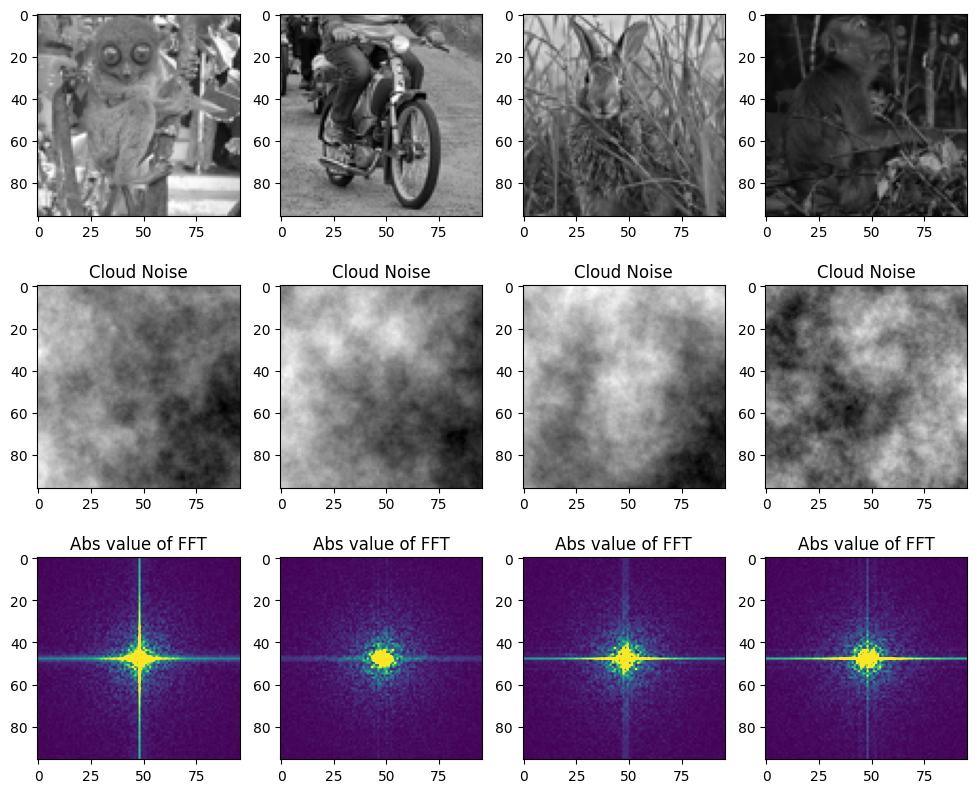

In [22]:
print(f"Noise for Delta={Delta}, A={A}")
    
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))
# Our noise generator returns complex noise in real space (z), and in Fourier space (Z)
z, Z = noise_generator.generate_monochrome_noise(A=A, batch_size=4, Delta=Delta)
x = z.real
X = fft(x).abs()

for i in range(4):
    randint = np.random.randint(len(clean_dataset))
    image = clean_dataset[randint][0].squeeze()
    axs[1][i].set_title(f"Image from Dataset")
    axs[0][i].imshow(image, vmin=0, vmax=1, cmap="gray")
    axs[1][i].set_title(f"Cloud Noise")
    axs[1][i].imshow(x[i].real.squeeze().to("cpu"), cmap="gray")
    axs[2][i].set_title(f"Abs value of FFT")
    axs[2][i].imshow(X[i].squeeze().to("cpu"), vmin=0, vmax=1)
plt.show()

Above we've shown a row of images from the dataset (for comparison purposes), Cloud Noise from the noise generator, and the Real Fast Fourier Transform of the Cloud Noise. While the Cloud Noise certainly doesn't look like a real image from the set, it is certainly closer to the image set than white noise. And, you can see now why we call it **Cloud Noise** -- because it looks like clouds! This noise will be the basis for our Cloud Diffusion model, where it replaces white noise in the forward diffusion process.

## Whitening Transformations
Analyzing correlations between neighboring pixels are the key to coming up with a strategy for guessing pixel values. But, suppose we could remove the spatial correlations? How could we do this? What would the resulting images look like?

As it happens, there is a procedure for removing spatial correlations, and it is referred to as a "whitening transformation", as it takes an distribution that can be approximated by a normal distribution and removes the spatial correlations so that the variance tensor becomes diagonal with a flat profile, ${\Sigma^{ij}}_{kl}\approx \delta^i_k \delta^j_l$, just like white noise. For our image set, the trick is to retreat to Fourier Space, multiply each image by $|k|^{\Delta}$. The resulting variance tensor is (approximately) diagonal with a flat profile, so if we inverse Fourier transform back to real space, the variance tensor will also be (approximately) diagonal and flat. 

Let's see how this works...

In [1]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
eps = .001

for i in range(4):
    # Show original images
    randint = np.random.randint(len(clean_dataset))
    x = clean_dataset[randint][0].squeeze().to("cpu")
    axs[0][i].imshow(x, vmin=0, vmax=1, cmap="gray")
    axs[0][i].set_title(f"Original Image {i}")
    
    # Show Real Fourier Transform of images
    a=.3
    X = rfft(helpers.normalize(x, mu, std))
    axs[1][i].imshow(X, vmin=-a, vmax=a)
    axs[1][i].set_title(f"RFFT Image {i}")
    
    # Show whitened images in Real Fourier Space
    a=.1
    d = noise_generator.dist.to("cpu").squeeze()
    X_flat = X*(d+eps)**(Delta)
    axs[2][i].imshow(X_flat, vmin=-a, vmax=a)
    axs[2][i].set_title(f"Whitened RFFT {i}")
    
    # Show whitened images in real space
    a = .05
    x_flat = irfft(X_flat)
    axs[3][i].imshow(x_flat, cmap="gray", vmin=-a, vmax=a)
    axs[3][i].set_title(f"Whitened Image {i}")
    

# Remove axes labels
plt.setp(axs, xticks=[], yticks=[])

plt.show()

NameError: name 'plt' is not defined

Notice that the whitened images are still recognizable, but the procedure has removed the big blocks of value while retaining the outlines of objects. We won't do it here, but we can confirm that the variance tensor for the whitened images in real space is approximately diagonal with a flat profile.

This opens the door for another type of diffusion model. Rather than adjusting the noise to fit the images better, as we will do with the Cloud Diffusion models, we can adjust the images themselves to fit the noise! This serves a similar purpose...it brings the image and noise distributions closer together. The advantage to this is that after we've modified the image set, the noising, diffusion, and training are all identical to the procedures for ordinary diffusion models.

## What to Wager?
Coming back to our hypothetical bet that we introduced at the begining of this notebook...what is your strategy for chosing pixel values and what should you wager? While we won't answer that question directly, we have given you some tools that you can use for guessing pixel values. Cloud noise with with parameter $\Delta$ tuned to the image set gives us a nice model that captures some of the basic properties of the image set, namely the second-order correlations between neighboring pixels.   You could, for example, use the noise generator to model the image set and analyze its statistical properties to come up with a strategy for choosing pixel values to fill in the table above. Most importantly, since the correlations between neighboring points falls off with a distance function that is characteristic of the image set, your confidence in your guesses for random pixel values given a a sample pixel should also fall off with distance. And your wager should be adjusted accordingly. 

If you wanted to go deeper you could try to capture higher order effects -- kurtosis is a general term for the measure of non-Gaussianity of a probability distribution, and it is generally measured by fourth order correlation functions. Natural image sets do in fact exhibit characteristic kurtosis, which has been studied (cite Srivastrata et al.). This could give you a more sophisticated model to adjust your wagers.

But of course, this is not really about the wager! It's about diffusion models. And in the next notebook, [Cloud Diffusion Part 2: Overview (this notebook)](./CD_Overview.ipynb), we will show how to use Cloud Noise to replace White Noise in generative diffusion models, and why we think it could give better results.